In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
exp_id = 0

model_name = 'train_mnist_exp%d.h5' % exp_id
net = BasicModel()

# model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
# net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

In [4]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [11]:
y_pred = net(x_test.to(device))

In [12]:
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9878

In [7]:
# x_train = x_train.to(device)
# x_test = x_test.to(device)
# x_valid = x_valid.to(device)

In [6]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['relu3']
# layers = ['en_conv3']
# layers = ['en_mu']
# net = net.cpu()
with torch.no_grad():
    dknn = DKNN(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
                k=75, num_classes=10)
    y_pred = dknn.classify(x_test)

In [14]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.9879

In [15]:
cred = dknn.credibility(y_pred)

(array([ 890.,  467.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8643.]),
 array([0.00716667, 0.10645   , 0.20573333, 0.30501667, 0.4043    ,
        0.50358333, 0.60286667, 0.70215   , 0.80143333, 0.90071667,
        1.        ]),
 <a list of 10 Patch objects>)

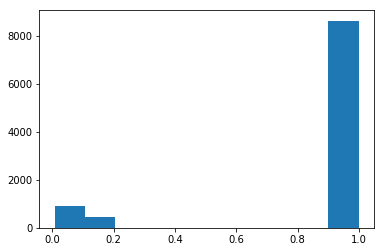

In [16]:
plt.hist(cred)

In [17]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

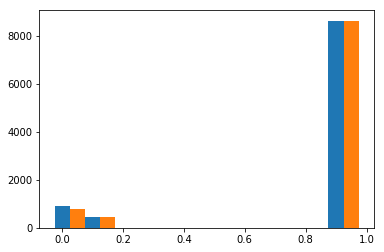

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [75]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.68107477, 0.94010695, 0.985138  , 0.98237885, 0.99356223,
              nan,        nan,        nan,        nan, 0.99982996])

In [25]:
dknn.A.mean()

5.7895

In [154]:
nn = dknn.get_neighbors(x_valid)

In [15]:
for (D, I) in nn:
    print(D[-1].mean())

0.72602546
0.6874378
0.7105881
0.94844836


## PGD Attack

In [12]:
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.numpy()

In [13]:
model = foolbox.models.PyTorchModel(net, bounds=(0, 1), num_classes=10)

In [6]:
criterion = foolbox.criteria.Misclassification()
distance = foolbox.distances.Linfinity

attack = foolbox.attacks.RandomPGD(
    model, criterion=criterion, distance=distance)

def attack_wrap(x, y):
    return attack(x, y, binary_search=False, epsilon=0.3, 
                  stepsize=0.01, iterations=40, 
                  random_start=True, return_early=True)

x_adv = np.zeros_like(x_test)
for i, (x, y) in enumerate(zip(x_test, y_test)):
    x_adv[i] = attack_wrap(x, y)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


In [ ]:
with torch.no_grad():
    x_adv = torch.tensor(x_adv).to(device)
    y_pred = net(x_adv).detach().cpu().numpy()
np.mean(np.argmax(y_pred, 1) == y_test)

In [ ]:
from lib.pgd_attack import PGDAttack

attack = PGDAttack()
x_adv = attack(net, x_test, y_test.to(device),
               targeted=False, epsilon=0.1, max_epsilon=0.3,
               max_iterations=20, random_restart=10)

In [23]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test).sum()

tensor(0)

In [54]:
y_pred = dknn.classify(x_adv.cpu())
(y_pred.argmax(1) == y_test.numpy()).sum()

813

(array([9.63e+03, 2.96e+02, 5.70e+01, 7.00e+00, 5.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 4.00e+00]),
 array([0.00383333, 0.10345   , 0.20306667, 0.30268333, 0.4023    ,
        0.50191667, 0.60153333, 0.70115   , 0.80076667, 0.90038333,
        1.        ]),
 <a list of 10 Patch objects>)

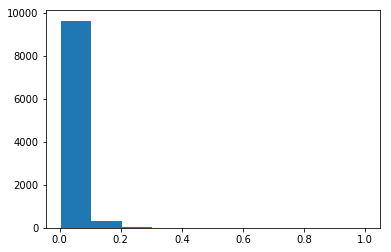

In [55]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [11]:
np.mean(y_pred == y_test)

0.9091

## DkNN Attack

In [13]:
attack = DKNNAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=5,
            max_iterations=500, learning_rate=1e-1,
            initial_const=1e2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000], 100)

    step: 0; loss: -515.421; l2dist: 0.000
    step: 50; loss: -522.762; l2dist: 2.138
    step: 100; loss: -528.006; l2dist: 2.299
    step: 150; loss: -529.452; l2dist: 2.282
    step: 200; loss: -529.801; l2dist: 2.294
    step: 250; loss: -529.944; l2dist: 2.302
    step: 300; loss: -530.002; l2dist: 2.305
    step: 350; loss: -530.031; l2dist: 2.309
    step: 400; loss: -530.048; l2dist: 2.311
    step: 450; loss: -530.057; l2dist: 2.314
tensor(76, device='cuda:0')
binary step: 0; number of successful adv: 76/100
    step: 0; loss: -1422.289; l2dist: 0.000
    step: 50; loss: -1460.969; l2dist: 2.330
    step: 100; loss: -1477.214; l2dist: 2.587
    step: 150; loss: -1479.838; l2dist: 2.535
    step: 200; loss: -1480.967; l2dist: 2.505
    step: 250; loss: -1481.530; l2dist: 2.484
    step: 300; loss: -1481.849; l2dist: 2.474
    step: 350; loss: -1482.036; l2dist: 2.469
    step: 400; loss: -1482.151; l2dist: 2.469
    step: 450; loss: -1482.220; l2dist: 2.468
tensor(69, device='

    step: 350; loss: -530.139; l2dist: 2.332
    step: 400; loss: -530.155; l2dist: 2.334
    step: 450; loss: -530.163; l2dist: 2.336
tensor(75, device='cuda:0')
binary step: 0; number of successful adv: 75/100
    step: 0; loss: -1475.680; l2dist: 0.000
    step: 50; loss: -1515.766; l2dist: 2.450
    step: 100; loss: -1529.391; l2dist: 2.659
    step: 150; loss: -1531.819; l2dist: 2.586
    step: 200; loss: -1532.852; l2dist: 2.550
    step: 250; loss: -1533.375; l2dist: 2.528
    step: 300; loss: -1533.670; l2dist: 2.520
    step: 350; loss: -1533.881; l2dist: 2.520
    step: 400; loss: -1534.008; l2dist: 2.516
    step: 450; loss: -1534.070; l2dist: 2.517
tensor(68, device='cuda:0')
binary step: 1; number of successful adv: 100/100
    step: 0; loss: -884.064; l2dist: 0.000
    step: 50; loss: -903.611; l2dist: 2.165
    step: 100; loss: -912.283; l2dist: 2.316
    step: 150; loss: -914.259; l2dist: 2.301
    step: 200; loss: -914.881; l2dist: 2.296
    step: 250; loss: -915.150; 

    step: 100; loss: -1374.579; l2dist: 2.496
    step: 150; loss: -1377.114; l2dist: 2.479
    step: 200; loss: -1378.105; l2dist: 2.446
    step: 250; loss: -1378.542; l2dist: 2.434
    step: 300; loss: -1378.763; l2dist: 2.426
    step: 350; loss: -1378.898; l2dist: 2.424
    step: 400; loss: -1378.983; l2dist: 2.420
    step: 450; loss: -1379.040; l2dist: 2.420
tensor(61, device='cuda:0')
binary step: 1; number of successful adv: 100/100
    step: 0; loss: -821.332; l2dist: 0.000
    step: 50; loss: -837.928; l2dist: 2.186
    step: 100; loss: -845.724; l2dist: 2.264
    step: 150; loss: -847.592; l2dist: 2.271
    step: 200; loss: -848.173; l2dist: 2.267
    step: 250; loss: -848.400; l2dist: 2.265
    step: 300; loss: -848.500; l2dist: 2.269
    step: 350; loss: -848.552; l2dist: 2.272
    step: 400; loss: -848.580; l2dist: 2.273
    step: 450; loss: -848.594; l2dist: 2.275
tensor(69, device='cuda:0')
binary step: 2; number of successful adv: 100/100
    step: 0; loss: -557.075; 

    step: 450; loss: -1381.735; l2dist: 2.484
tensor(77, device='cuda:0')
binary step: 1; number of successful adv: 100/100
    step: 0; loss: -779.693; l2dist: 0.000
    step: 50; loss: -796.260; l2dist: 1.998
    step: 100; loss: -804.735; l2dist: 2.141
    step: 150; loss: -806.481; l2dist: 2.163
    step: 200; loss: -807.058; l2dist: 2.159
    step: 250; loss: -807.298; l2dist: 2.163
    step: 300; loss: -807.405; l2dist: 2.165
    step: 350; loss: -807.459; l2dist: 2.168
    step: 400; loss: -807.493; l2dist: 2.170
    step: 450; loss: -807.512; l2dist: 2.171
tensor(64, device='cuda:0')
binary step: 2; number of successful adv: 100/100
    step: 0; loss: -522.110; l2dist: 0.000
    step: 50; loss: -530.708; l2dist: 1.789
    step: 100; loss: -536.366; l2dist: 1.956
    step: 150; loss: -537.648; l2dist: 1.969
    step: 200; loss: -538.020; l2dist: 1.991
    step: 250; loss: -538.167; l2dist: 2.001
    step: 300; loss: -538.234; l2dist: 2.009
    step: 350; loss: -538.268; l2dist: 

In [25]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.091

(array([979.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.]),
 array([0.015 , 0.1135, 0.212 , 0.3105, 0.409 , 0.5075, 0.606 , 0.7045,
        0.803 , 0.9015, 1.    ]),
 <a list of 10 Patch objects>)

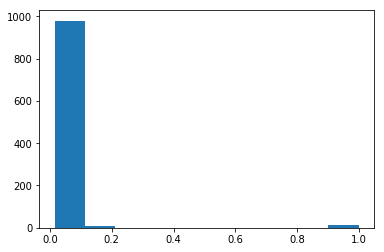

In [26]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

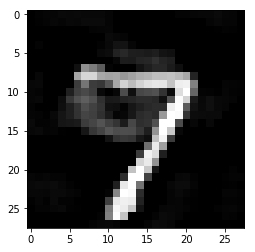

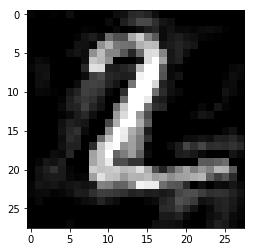

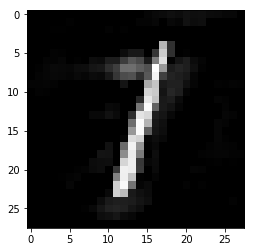

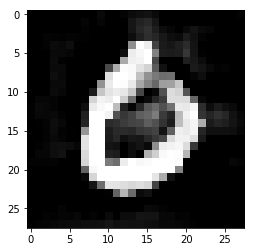

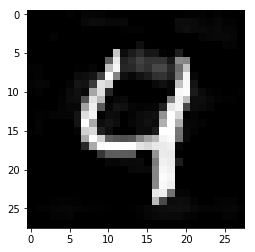

In [27]:
for i in range(5):
    plt.imshow(x_adv[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

In [28]:
y_clean = dknn.classify(x_test[:1000])
ind = (y_clean.argmax(1) == y_test[:1000].numpy()) & (y_pred.argmax(1) != y_test[:1000].numpy())
np.mean(np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:1000][ind])**2, (1, 2, 3))))

2.0539396

## CW L2 Attack

without DkNN

In [ ]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000].cuda(), 100)

In [273]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test[:1000]).numpy().sum() / y_pred.size(0)

AttributeError: 'tuple' object has no attribute 'argmax'

In [274]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.702

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

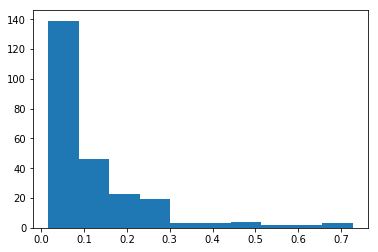

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:1000].numpy()
plt.hist(cred[suc_ind])

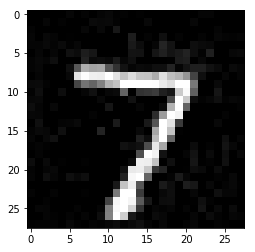

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [88]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(0.7349, grad_fn=<MeanBackward1>)

---

In [27]:
# Set all random seeds
exp_id = 0
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'train_mnist_cav_exp%d.h5' % exp_id
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [32]:
x_train = x_train.to(device)
x_test = x_test.to(device)
x_valid = x_valid.to(device)

In [28]:
net

ClassAuxVAE(
  (en_conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (en_conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (en_conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (en_fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU(inplace)
  (en_mu): Linear(in_features=128, out_features=20, bias=True)
  (en_logvar): Linear(in_features=128, out_features=20, bias=True)
  (de_fc1): Linear(in_features=20, out_features=128, bias=True)
  (de_fc2): Linear(in_features=128, out_features=1568, bias=True)
  (ax_fc1): Linear(in_features=20, out_features=128, bias=True)
  (ax_fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [59]:
layers = ['en_mu']
net = net.to(device)
with torch.no_grad():
    dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [60]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.964

(array([ 741., 1243.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8016.]),
 array([0.01683333, 0.11515   , 0.21346667, 0.31178333, 0.4101    ,
        0.50841667, 0.60673333, 0.70505   , 0.80336667, 0.90168333,
        1.        ]),
 <a list of 10 Patch objects>)

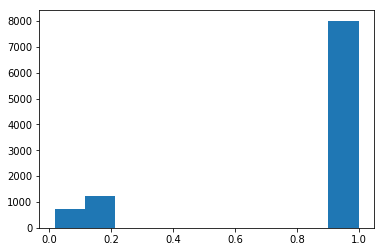

In [61]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [62]:
from lib.dknn_attack import DKNNAttack

attack = DKNNAttack()
x_adv = attack(dknn, x_test[:1000], y_test[:1000],
               guide_layer='en_mu', binary_search_steps=5,
               max_iterations=500, learning_rate=1e-1,
               initial_const=1, abort_early=True)

    step: 0; loss: -10.374; l2dist: 0.000
    step: 50; loss: -16.516; l2dist: 2.206
    step: 100; loss: -17.532; l2dist: 2.233
    step: 150; loss: -21.379; l2dist: 2.383
    step: 200; loss: -23.950; l2dist: 2.461
    step: 250; loss: -25.525; l2dist: 2.522
    step: 300; loss: -26.562; l2dist: 2.575
    step: 350; loss: -27.237; l2dist: 2.610
    step: 400; loss: -27.690; l2dist: 2.641
    step: 450; loss: -27.980; l2dist: 2.662
binary step: 0; number of successful adv: 732/1000
    step: 0; loss: -31.082; l2dist: 0.000
    step: 50; loss: -80.035; l2dist: 2.555
    step: 100; loss: -102.080; l2dist: 2.891
    step: 150; loss: -113.852; l2dist: 3.048
    step: 200; loss: -119.545; l2dist: 3.074
    step: 250; loss: -122.952; l2dist: 3.069
    step: 300; loss: -125.118; l2dist: 3.057
    step: 350; loss: -126.465; l2dist: 3.052
    step: 400; loss: -127.398; l2dist: 3.048
    step: 450; loss: -127.963; l2dist: 3.048
binary step: 1; number of successful adv: 1000/1000
    step: 0; lo

In [18]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum()

0

In [40]:
x.size()

torch.Size([1000, 128, 4, 4])

In [41]:
F.normalize(x.view(1000, -1), 2, 1).norm(2, 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

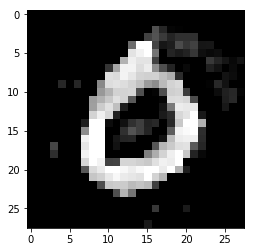

In [56]:
plt.imshow(x_adv[3].cpu().detach().numpy().squeeze(), cmap='gray')

In [20]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(1.9813, grad_fn=<MeanBackward1>)

---
# Soft DkNN

In [ ]:
def attack_soft_dknn(dknn, x):
    
    train_reps = dknn.get_activations(dknn.x_train)[dknn.layers[0]]
    dknn.model

In [14]:
with torch.no_grad():
    train_reps = dknn.get_activations(dknn.x_train)[dknn.layers[0]]
    train_reps = F.normalize(train_reps.view(dknn.x_train.size(0), -1), 2, 1)
    test_reps = dknn.get_activations(x_test)[dknn.layers[0]]
    test_reps = F.normalize(test_reps.view(x_test.size(0), -1), 2, 1)

In [7]:
temp = 2e-2
k = 75

with torch.no_grad():
    logits = torch.empty((x_test.size(0), dknn.num_classes))
    for i, tr in enumerate(test_reps):
        cos = ((tr.unsqueeze(0) * train_reps).sum(1) / temp).exp()
#         cos = (tr.unsqueeze(0) * train_reps).sum(1)
        for label in range(dknn.num_classes):
#             logits[i, label] = cos[dknn.y_train == label].topk(k)[0].mean()
            logits[i, label] = cos[dknn.y_train == label].mean()

NameError: name 'test_reps' is not defined

In [24]:
(logits.argmax(1) == y_test).float().mean().item()

0.9905999898910522

In [15]:
(logits.argmax(1) == y_test).float().mean().item()

0.9771000146865845

In [20]:
logits[:10]

tensor([[9.0623e+16, 1.4147e+18, 1.2181e+22, 3.3628e+24, 2.3893e+28, 2.2911e+16,
         2.7718e+04,        inf, 5.7814e+18, 7.3722e+28],
        [1.3863e+20, 1.6077e+23,        inf, 1.9961e+20, 2.8452e+13, 1.6902e+13,
         2.6469e+24, 2.4233e+16, 2.0720e+20, 1.9177e+09],
        [2.5690e+18,        inf, 1.4419e+20, 9.1542e+14, 3.2405e+25, 3.7392e+20,
         3.5755e+23, 1.8295e+28, 3.5247e+28, 3.4260e+23],
        [       inf, 3.9173e+12, 3.2005e+15, 1.5079e+18, 6.8862e+13, 1.1675e+20,
         1.3331e+26, 2.1042e+20, 6.5407e+15, 1.0673e+20],
        [1.2631e+15, 7.9582e+10, 1.5084e+14, 5.8053e+12,        inf, 4.5395e+14,
         2.0079e+19, 8.2885e+17, 3.4067e+18, 2.8828e+32],
        [1.7659e+19,        inf, 2.7190e+20, 3.5235e+15, 5.9625e+24, 1.7116e+20,
         3.0330e+21, 9.7796e+30, 6.7487e+30, 2.6304e+24],
        [9.5577e+05, 1.7322e+17, 2.7370e+14, 4.3173e+12, 4.6950e+33, 1.0589e+16,
         4.7079e+12, 6.7882e+20, 9.7778e+25, 2.7883e+29],
        [1.5633e+12, 1.1039

In [9]:
y_pred = dknn.classify_soft(x_test, k=20)

In [11]:
(y_pred.argmax(1) == y_test).float().mean().item()

0.9897000193595886

In [8]:
from lib.dknn_attack import SoftDKNNAttack

attack = SoftDKNNAttack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            layer=layers[0], m=100, binary_search_steps=5,
            max_iterations=500, learning_rate=1e-1,
            initial_const=1e2, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000].cuda(), 100)

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 10.91 GiB total capacity; 9.76 GiB already allocated; 8.50 MiB free; 61.01 MiB cached)

In [9]:
y_onehot = torch.zeros((100, 10))

y_onehot.scatter_(1, , 1)

RuntimeError: invalid argument 3: Index tensor must either be empty or have same dimensions as output tensor at /opt/conda/conda-bld/pytorch_1544199946412/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:531